In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.datasets import fetch_openml
import warnings 
warnings.filterwarnings("ignore")

In [37]:
## Loading MNIST dataset
mnist = fetch_openml("mnist_784", version=1)

In [38]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [39]:
X, y = mnist["data"], mnist["target"]

In [40]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [42]:
X.shape

(70000, 784)

In [43]:
y.shape

(70000,)

There are 70000 images and each images has 784 features (28*28 pixels).

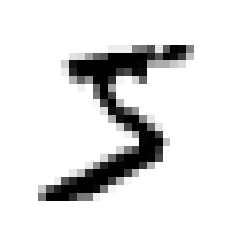

In [44]:
## Let's take a peek at one digit from the dataset
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [45]:
## Here I am defining a function to plot any data from the dataset
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [46]:
## Here I am defining a function to plot a set of images
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

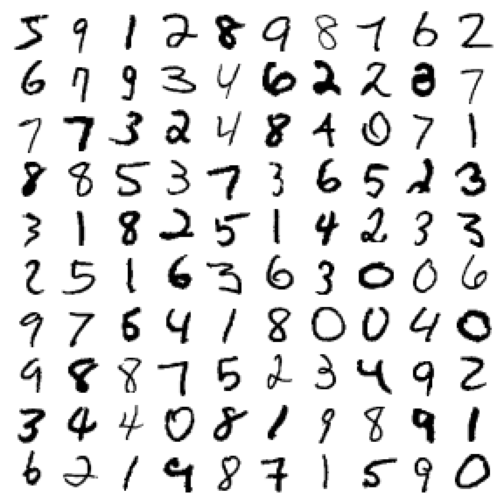

In [47]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [48]:
y[2]

'4'

In [49]:
y.dtype

dtype('O')

In [50]:
type(X)

numpy.ndarray

In [51]:
type(y)

numpy.ndarray

In [52]:
## The label is a string, so let's cast it to integers
y = y.astype(np.uint8)

In [53]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [54]:
## Let's split the dataset into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let's simplify the problem fro now and only try to identify a digit (number 5).

In [55]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [56]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [57]:
y_test_5

array([False, False, False, ..., False,  True, False])

Let's pick a classifier and train it. Let's get started with Stochastic Gradient Descent (SGD) which really good for handling efficiently large datasets.

In [58]:
from sklearn.linear_model import SGDClassifier

In [59]:
sgd_clf = SGDClassifier(random_state=42)

In [60]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
## Prediction
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

Measuring Accuracy Using Cross-Validation

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [63]:
## Implementing a customized Cross-Validation 

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [64]:
from sklearn.model_selection import cross_val_score

In [65]:
## Now let's use the cross_val_score()
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow!! more than 95 % accuracy. That is amazing! 
However, before being super happy, let's check out a classifer that is classifying every single image as "not-5"

In [66]:
from sklearn.base import BaseEstimator

In [67]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [68]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Now we are 90% accuracy because 10% of the daaset are 5s. 
This example shows us why accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets.
Now let's see other performance measures.

Confusion mtrix

In [69]:
from sklearn.model_selection import cross_val_predict

In [70]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [71]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [72]:
from sklearn.metrics import confusion_matrix

In [73]:
## Now let's apply the confusion matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Precision and Recall 

In [74]:
from sklearn.metrics import precision_score, recall_score

In [75]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [76]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When it claims an image represents a 5, it is correct 83.7% of the time. In addition, it only detects 65.11% of the 5s. This does not look shiny as it did when we looked at its accuracy.

In [77]:
from sklearn.metrics import f1_score

In [78]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

# Precision/Recall Tradeoff

In [79]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [80]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [81]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

We can decide for which threshold to use by firstly getting the scores of all instances in the training set using the cross_val_predict() function, but this time specifying that you want it to return decisions scores instead of predictions.

In [82]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now let's compute precision and recall for all possible threshold using the precision_recall_curve()

In [83]:
from sklearn.metrics import precision_recall_curve

In [84]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

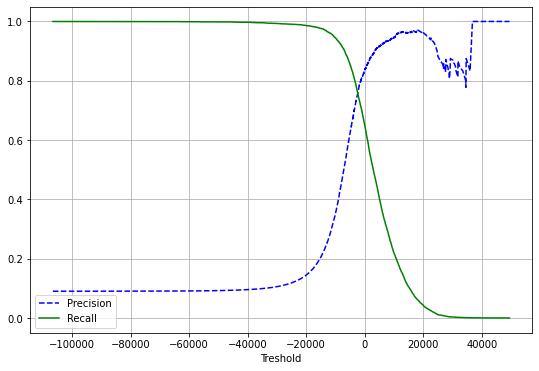

In [85]:
## Finally, let's plot precision and recall as functions of the threshold value

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Treshold")
    plt.grid()
    plt.legend()

plt.figure(figsize=(9,6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

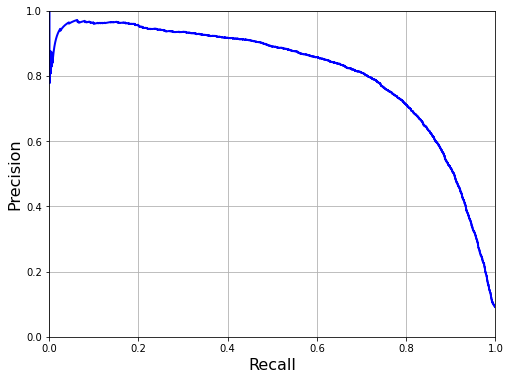

In [86]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid()

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

So here the selection of the precision/recall tradeoff depends on the project.

In [87]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [88]:
## So now we can make prediction using this 90% precision threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [89]:
## Let's check the precision 
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [90]:
## let's check the recall 
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# The ROC Curve

ROC - Receiver Operating Characteristic

In [91]:
from sklearn.metrics import roc_curve

In [92]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

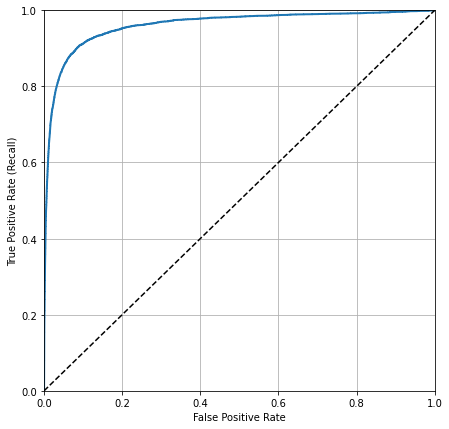

In [93]:
def plot_roc_curve(fpr, tpr, label=None):
    # plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr, Linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # dashed diagonal
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.figure(figsize=(7,7))
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to mesure the area under the curve (AUC)

In [94]:
from sklearn.metrics import roc_auc_score

In [95]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

let's train the RandomForestClassifier

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

To plot the ROC curve, we need scores so we will use the positive class's probability as the score

In [98]:
y_scores_forest = y_proba_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

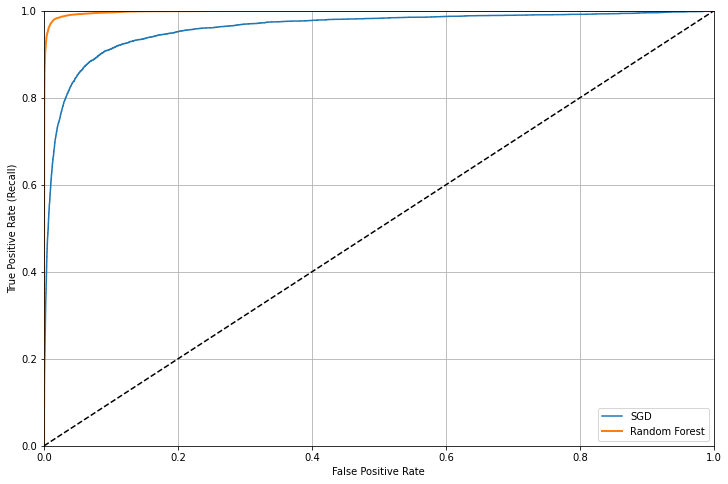

In [99]:
## Now let's plot the ROC curves of comparison
plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [100]:
## let's mesure the area under the curve (AUC) for the RandomForestClassifier
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [101]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [102]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [103]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass Classification

In [104]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [106]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [107]:
np.argmax(some_digit_scores)

3

We can see here that the prediction is not good. Instead of 5 we predicted 3.

In [108]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

We can force Scikit-Learn to use one-versus-one or one-versus-all

In [109]:
from sklearn.multiclass import OneVsOneClassifier

In [110]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [112]:
some_digit_scores = ovo_clf.decision_function([some_digit])
some_digit_scores

array([[2.66666696, 3.66666714, 5.33333258, 8.33333319, 0.6666669 ,
        9.33333315, 0.66666684, 2.66666841, 5.33333214, 6.33333275]])

In [113]:
np.argmax(some_digit_scores)

5

With the one vs one classifier, the prediction is accurate.

In [111]:
len(ovo_clf.estimators_)

45

In [114]:
## Now let's train the random forest classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

With the Random Forest classifier, the prediction is also accurate.

In [115]:
## let's call predict_proba() to know the probability assigned to each instance
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [116]:
## Lets evaluate the accuracy of SGDClassifier 
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [117]:
## Lets evaluate the accuracy of RandomForestClassifier 
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

In [118]:
## Let's scale the training set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [119]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [120]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
y_train_pred

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [121]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

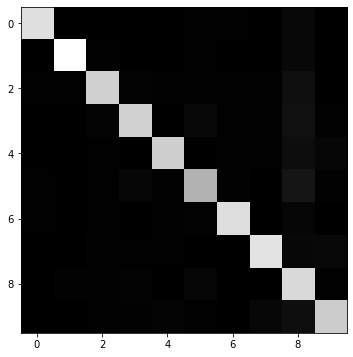

In [122]:
plt.figure(figsize=(6,6))
plt.imshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [123]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

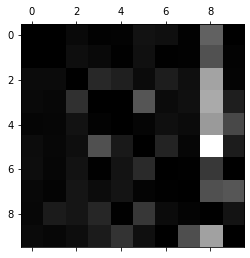

In [124]:
## Now let's fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

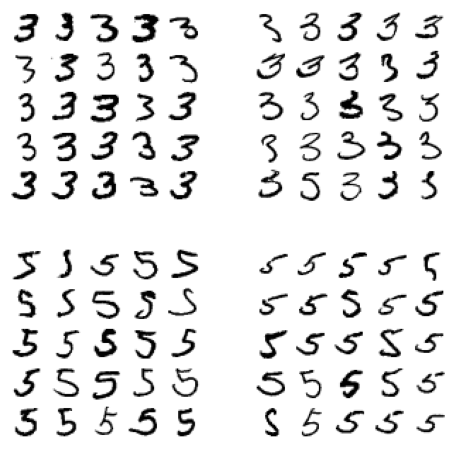

In [125]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification

In [126]:
from sklearn.neighbors import KNeighborsClassifier

In [127]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [128]:
knn_clf = KNeighborsClassifier()

In [129]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [130]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [132]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [133]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

In [134]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

In [135]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [136]:
y_train_mod = X_train
y_test_mod = X_test

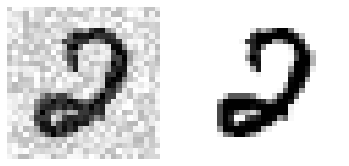

In [138]:
some_index = 400
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])
plt.show()

In [139]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

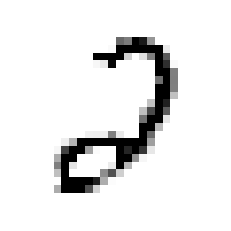

In [140]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)